In [1]:
# Pre-processing dependencies

from scipy.io import loadmat
from scipy.io import savemat
from scipy.stats import kurtosis, skew, entropy
from scipy import signal
import pandas as pd
import numpy as np

from sklearn import preprocessing

In [2]:
# Classifier dependencies

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from function import classification

In [3]:
# Plotting dependencies

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
involuntary = loadmat('dataset/jap_blink_involuntary.mat')['jap_blink_involuntary']
channels = ["Fp1","Fp2", "F3", "F4", "T3", "C3", "Cz", "C4", "T4", "P3", "Pz", "P4", "O1", "O2"]

Fs = 256
eeg_bands = {'delta': (0, 4),
             'eog': (3, 4),
             'theta': (4, 8),
             'alpha': (8, 12),
             'beta': (12, 30),
             'gamma': (30, 45)}

In [5]:
features = pd.DataFrame()

# channels x points x epochs (14x1024x394)
def extract_data(filename, dataframe, is_voluntary):
    data = loadmat('dataset/' + filename + '.mat')[filename]

    # iterate per epoch
    for i in range (data.shape[2]):
        sub_data = data[:, :, i]
        new_record = {}
        # iterate per channel
        for j in range (sub_data.shape[0]):

            #sub2_data is the signal
            sub2_data = data[j,:,i]
            new_record[channels[j] + '_mean'] = np.mean(sub2_data)
            new_record[channels[j] + '_median'] = np.median(sub2_data)
            new_record[channels[j] + '_min'] = np.min(sub2_data)
            new_record[channels[j] + '_max'] = np.max(sub2_data)
            new_record[channels[j] + '_range'] = np.max(sub2_data) - np.min(sub2_data)
            new_record[channels[j] + '_std'] = np.std(sub2_data)
            new_record[channels[j] + '_var'] = np.var(sub2_data)
            new_record[channels[j] + '_kurtosis'] = kurtosis(sub2_data)
            new_record[channels[j] + '_skew'] = skew(sub2_data)

            # Power Spectral Density
            f, sub2_psd = signal.welch(sub2_data, Fs, nperseg=1024)
            sub2_psd = 10 * np.log10(sub2_psd)

            new_record['f_max_power'] = f[np.argmax(sub2_psd)]

            for band in ['delta', 'eog', 'theta']:
                # f_indices = np.where((f >= eeg_bands[band][0]) & (f < eeg_bands[band][1]))
                f_indices = f[(f >= eeg_bands[band][0]) & (f < eeg_bands[band][1])]
                psd_indices = sub2_psd[(f >= eeg_bands[band][0]) & (f < eeg_bands[band][1])]
                prefix = channels[j] + '_' + band
                new_record[prefix + '_psd_mean'] = np.mean(psd_indices)
                new_record[prefix + '_psd_median'] = np.median(psd_indices)
                new_record[prefix + '_psd_min'] = np.min(psd_indices)
                new_record[prefix + '_psd_max'] = np.max(psd_indices)
                new_record[prefix + '_psd_range'] = np.max(psd_indices)- np.min(psd_indices)
                new_record[prefix + '_psd_std'] = np.std(psd_indices)
                new_record[prefix + '_psd_var'] = np.var(psd_indices)

        new_record['is_voluntary'] = is_voluntary
        dataframe = pd.concat([dataframe, pd.DataFrame([new_record])], ignore_index=True)
    return dataframe

In [6]:
features = extract_data('epochs_blinks_ASR_invol', features, 0)
features = extract_data('epochs_blinks_ASR_vol', features, 1)

C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Edwin Sanjaya\AppData\Local\Temp\ipykernel_39628\391505207.py:28: RuntimeWarning: divide by zero encountered in log10
  sub2_psd = 10 * np.log10(sub2_psd)
C:\Users\Edwin Sanjaya\AppData\Local\Temp\ipykernel_39628\391505207.py:41: RuntimeWarning: invalid value encountered in scalar subtract
  new_record[prefix + '_psd_range'] = np.max(psd_indices)- np.min(psd_indices)
C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [7]:
channels[1] + '_mean'

'Fp2_mean'

In [8]:
features

,Fp1_mean,Fp1_median,Fp1_min,Fp1_max,Fp1_range,Fp1_std,Fp1_var,Fp1_kurtosis,Fp1_skew,f_max_power,...,Fp2_eog_psd_std,Fp2_eog_psd_var,Fp2_theta_psd_mean,Fp2_theta_psd_median,Fp2_theta_psd_min,Fp2_theta_psd_max,Fp2_theta_psd_range,Fp2_theta_psd_std,Fp2_theta_psd_var,is_voluntary
0,0.339050,0.000000,-6.713165,11.964565,18.677730,3.570963,12.751779,1.000273,0.836984,1.024,...,7.127702,50.804132,1.306787,1.518573,-13.792254,9.377258,23.169512,6.356310,40.402671,0
1,-0.075289,0.000000,-10.530016,33.463759,43.993775,3.556294,12.647224,26.540126,3.699811,1.280,...,8.857646,78.457901,-3.116214,-2.459370,-12.800736,5.951070,18.751806,5.384214,28.989757,0
2,0.425009,0.000000,-30.280985,17.223552,47.504537,5.147871,26.500573,5.132512,-0.282614,1.024,...,4.691439,22.009598,-3.747290,-5.166194,-15.102469,6.144972,21.247441,5.563422,30.951660,0
3,0.034600,-0.137332,-6.086516,8.187018,14.273534,2.449944,6.002226,0.327313,0.446394,1.024,...,2.951520,8.711472,-2.762290,-1.359810,-15.499014,6.927092,22.426106,5.850325,34.226300,0
4,-2.412935,-0.375307,-76.157007,73.381570,149.538576,23.682215,560.847321,2.276413,-0.519035,1.024,...,2.534957,6.426009,-0.280414,0.178416,-16.254301,11.915248,28.169549,7.992203,63.875304,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,-0.105753,-0.014991,-11.785157,9.227496,21.012653,2.866854,8.218850,1.279513,-0.172982,1.280,...,7.251050,52.577720,0.688749,1.047973,-13.013598,7.268693,20.282291,4.854331,23.564534,1
903,0.028822,0.092341,-13.135653,10.338592,23.474245,3.052816,9.319687,2.105370,-0.576837,1.024,...,2.365411,5.595170,1.316792,3.133998,-10.179746,9.067520,19.247266,5.342191,28.539004,1
904,0.168170,0.048133,-11.420757,8.002547,19.423303,2.695651,7.266536,1.102447,-0.139556,1.024,...,3.725131,13.876599,0.798199,0.620670,-4.304525,7.042758,11.347283,2.451951,6.012065,1
905,-0.028422,-0.121960,-11.021697,9.552465,20.574161,3.508806,12.311718,0.063347,-0.144436,1.024,...,6.148305,37.801654,-0.145860,-0.722000,-12.919766,10.472100,23.391866,6.166538,38.026197,1


In [9]:
features = features.replace([np.inf, -np.inf], np.nan)
features = features.dropna()

In [10]:
# Preparing the x (inputs) and y (output)
x = features.loc[:, features.columns != 'is_voluntary']
y = features.loc[:, features.columns == 'is_voluntary']
results = pd.DataFrame()

In [11]:
# Normalization on inputs
def normalize_mms(input_df):
    scaler = preprocessing.RobustScaler()
    result = scaler.fit_transform(input_df)
    return pd.DataFrame(result, index=input_df.index, columns=input_df.columns)

x = normalize_mms(x)

Train acc: 0.689873417721519
[[251  94]
 [102 185]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       345
           1       0.66      0.64      0.65       287

    accuracy                           0.69       632
   macro avg       0.69      0.69      0.69       632
weighted avg       0.69      0.69      0.69       632


Test acc: 0.6544117647058824
[[98 43]
 [51 80]]
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       141
           1       0.65      0.61      0.63       131

    accuracy                           0.65       272
   macro avg       0.65      0.65      0.65       272
weighted avg       0.65      0.65      0.65       272



C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


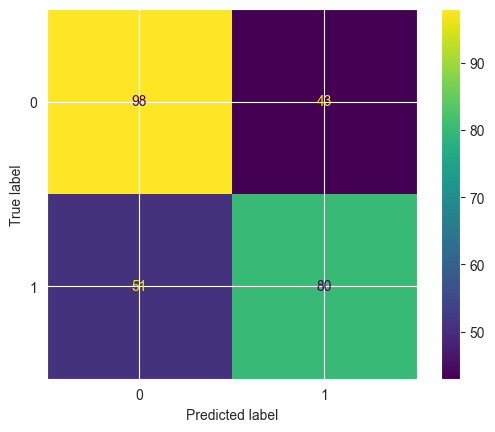

In [12]:
# Logistic Regression
LR = LogisticRegression(random_state=42)
accuracy, LR = classification.model_training(x, y.values.ravel(), LR)
results = pd.concat([results, pd.DataFrame([{'model': 'Logistic Regression', 'accuracy': accuracy}])], ignore_index=True)

C:\Users\Edwin Sanjaya\DataspellProjects\bci-finalproject\function\classification.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Train acc: 1.0
[[345   0]
 [  0 287]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       287

    accuracy                           1.00       632
   macro avg       1.00      1.00      1.00       632
weighted avg       1.00      1.00      1.00       632


Test acc: 0.6323529411764706
[[106  35]
 [ 65  66]]
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       141
           1       0.65      0.50      0.57       131

    accuracy                           0.63       272
   macro avg       0.64      0.63      0.62       272
weighted avg       0.64      0.63      0.63       272



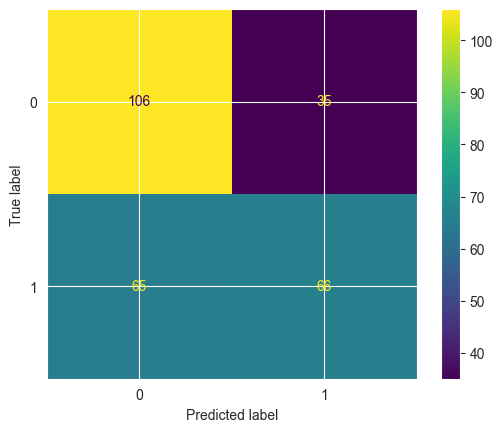

In [13]:
RF = RandomForestClassifier(random_state=42)
accuracy, RF = classification.model_training(x, y, RF)
results = pd.concat([results, pd.DataFrame([{'model': 'Random Forest', 'accuracy': accuracy}])], ignore_index=True)

C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train acc: 0.7816455696202531
[[285  60]
 [ 78 209]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       345
           1       0.78      0.73      0.75       287

    accuracy                           0.78       632
   macro avg       0.78      0.78      0.78       632
weighted avg       0.78      0.78      0.78       632


Test acc: 0.6544117647058824
[[104  37]
 [ 57  74]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       141
           1       0.67      0.56      0.61       131

    accuracy                           0.65       272
   macro avg       0.66      0.65      0.65       272
weighted avg       0.66      0.65      0.65       272



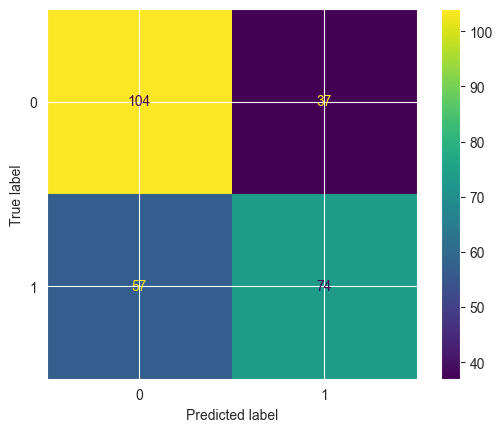

In [14]:
SVM = SVC(random_state=42)
accuracy, SVM = classification.model_training(x, y, SVM)
results = pd.concat([results, pd.DataFrame([{'model': 'Support Vector Machine', 'accuracy': accuracy}])], ignore_index=True)

Train acc: 1.0
[[345   0]
 [  0 287]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       287

    accuracy                           1.00       632
   macro avg       1.00      1.00      1.00       632
weighted avg       1.00      1.00      1.00       632


Test acc: 0.6470588235294118
[[100  41]
 [ 55  76]]
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       141
           1       0.65      0.58      0.61       131

    accuracy                           0.65       272
   macro avg       0.65      0.64      0.64       272
weighted avg       0.65      0.65      0.65       272



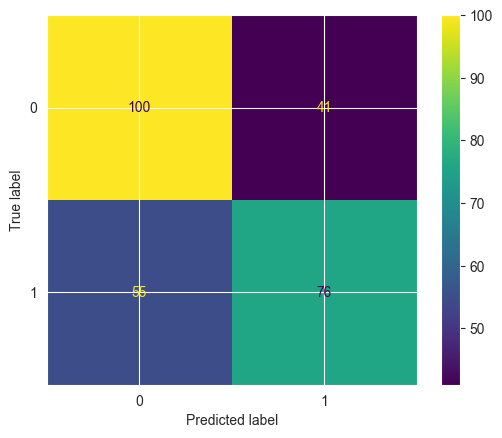

In [15]:
XGB = XGBClassifier()
accuracy, XGB = classification.model_training(x, y, XGB)
results = pd.concat([results, pd.DataFrame([{'model': 'XGBoost', 'accuracy': accuracy}])], ignore_index=True)

Train acc: 0.9335443037974683
[[320  25]
 [ 17 270]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       345
           1       0.92      0.94      0.93       287

    accuracy                           0.93       632
   macro avg       0.93      0.93      0.93       632
weighted avg       0.93      0.93      0.93       632


Test acc: 0.625
[[100  41]
 [ 61  70]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       141
           1       0.63      0.53      0.58       131

    accuracy                           0.62       272
   macro avg       0.63      0.62      0.62       272
weighted avg       0.63      0.62      0.62       272



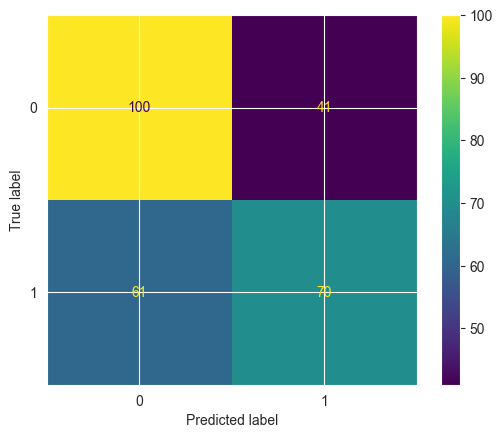

In [16]:
XGBRF = XGBRFClassifier()
accuracy, XGBRF = classification.model_training(x, y, XGBRF)
results = pd.concat([results, pd.DataFrame([{'model': 'XGBoost Random Forest', 'accuracy': accuracy}])], ignore_index=True)

Train acc: 0.6882911392405063
[[245 100]
 [ 97 190]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       345
           1       0.66      0.66      0.66       287

    accuracy                           0.69       632
   macro avg       0.69      0.69      0.69       632
weighted avg       0.69      0.69      0.69       632


Test acc: 0.6176470588235294
[[96 45]
 [59 72]]
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       141
           1       0.62      0.55      0.58       131

    accuracy                           0.62       272
   macro avg       0.62      0.62      0.61       272
weighted avg       0.62      0.62      0.62       272



C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


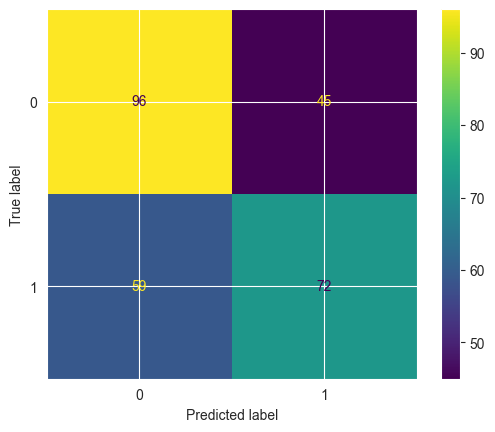

In [17]:
LDA = LinearDiscriminantAnalysis()
accuracy, LDA = classification.model_training(x, y, LDA)
results = pd.concat([results, pd.DataFrame([{'model': 'Linear Discriminant Analysis', 'accuracy': accuracy}])], ignore_index=True)

C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train acc: 0.7848101265822784
[[272  73]
 [ 63 224]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       345
           1       0.75      0.78      0.77       287

    accuracy                           0.78       632
   macro avg       0.78      0.78      0.78       632
weighted avg       0.79      0.78      0.79       632


Test acc: 0.6102941176470589
[[87 54]
 [52 79]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       141
           1       0.59      0.60      0.60       131

    accuracy                           0.61       272
   macro avg       0.61      0.61      0.61       272
weighted avg       0.61      0.61      0.61       272



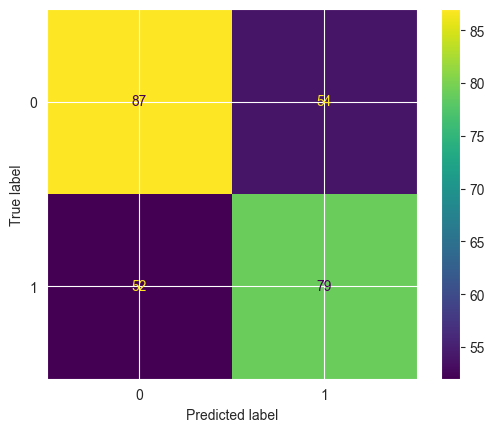

In [18]:
KNN = KNeighborsClassifier(n_neighbors=3)
accuracy, KNN = classification.model_training(x, y, KNN)
results = pd.concat([results, pd.DataFrame([{'model': 'K-Nearest Neighbors', 'accuracy': accuracy}])], ignore_index=True)

In [19]:
results

,model,accuracy
0,Logistic Regression,0.654412
1,Random Forest,0.632353
2,Support Vector Machine,0.654412
3,XGBoost,0.647059
4,XGBoost Random Forest,0.625000
5,Linear Discriminant Analysis,0.617647
6,K-Nearest Neighbors,0.610294


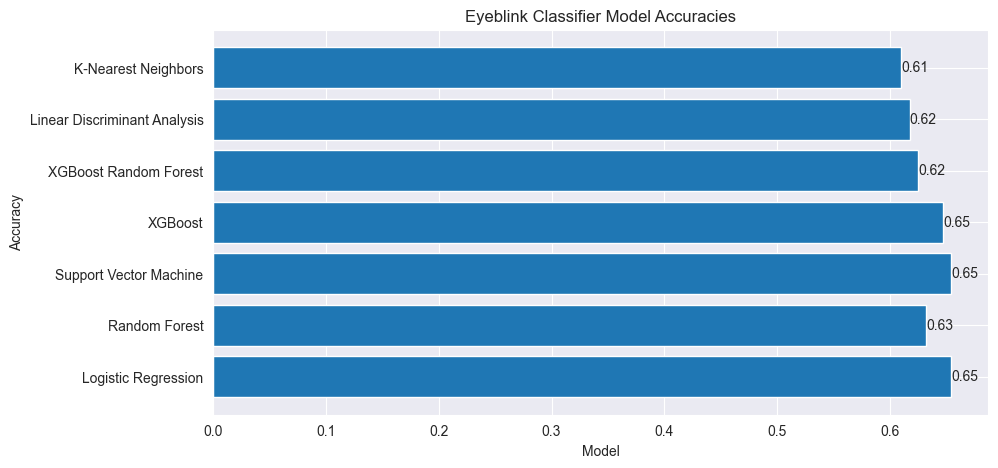

In [20]:
plt.figure(figsize=(10, 5))
bars = plt.barh(results['model'], results['accuracy'])
plt.title('Eyeblink Classifier Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
             ha='left', va='center')
plt.show()